In [ ]:
%pip install -r requirements.txt

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
%load_ext autoreload
%autoreload 2

import seaborn as sns
from sklearn.decomposition import PCA, IncrementalPCA
import cdflib
import os
os.makedirs('figures/', exist_ok=True)
os.makedirs('dataset/', exist_ok=True)

# Data variance

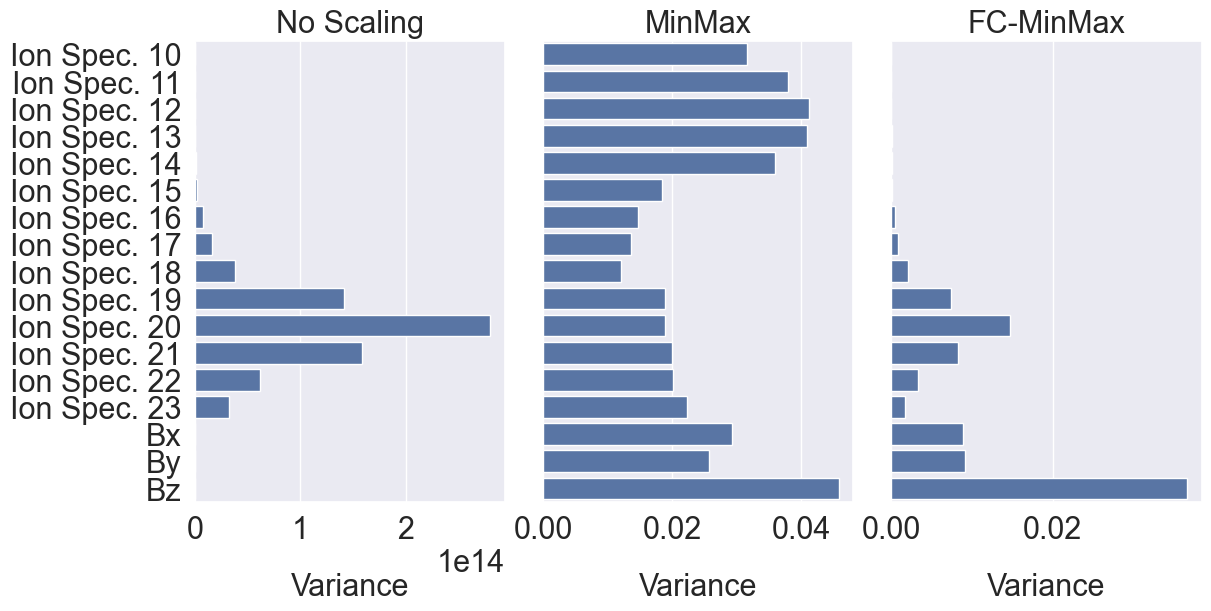

In [2]:
import datetime as dt
from detector import FeatureCoupledMinMaxScaler
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from dataset import PandasDataset

sns.set_theme()
plt.style.use('lncs_style_1.mplstyle')
    
from dataset import get_dataset

dataset = get_dataset('day')[1]

#Range over the magnetosheat
t1 = dt.datetime(2017, 12, 17,20,00)
t2 = dt.datetime(2017, 12, 17,21,50)

df = PandasDataset(dataset['name']).dataset.drop('label',axis=1)
df['Time'] = df.index
cols = [c for c in df.columns if c != 'Time']
df_l = df.loc[(df['Time'] > t1) & (df['Time'] < t2)]
    
scaler = MinMaxScaler((0,1),clip=False)

fc_scaler = FeatureCoupledMinMaxScaler([(0,32), (32,35),(35,38)], (0,1))
var_p = []
var_s = []
var_fc_s = []
indexes = [i for i in range(10,24)] + [32, 33, 34]
x = df_l[cols].to_numpy()
x_s = scaler.fit(x).transform(x)
x = df_l[cols].to_numpy()
x_fc = fc_scaler.fit(x).transform(x)
x = df_l[cols].to_numpy()
features = []
for i in indexes:
    var_p.append(np.var(x[:,i]))
    var_s.append(np.var(x_s[:,i]))
    var_fc_s.append(np.var(x_fc[:,i]))
    features.append(cols[i])
    
data = pd.DataFrame({
        'No Scaling': var_p,
        'MinMax': var_s,
        'FC-MinMax': var_fc_s,
        'Feature': features,
       })
fig,axs = plt.subplots(1,3 , sharey=True, figsize=(12, 6))
sns.barplot(data,ax=axs[0], y = 'Feature', x='No Scaling')    
axs[0].set_title('No Scaling')
axs[0].set_xlabel('Variance')
axs[0].set_ylabel('')
sns.barplot(data,ax=axs[1], y = 'Feature', x='MinMax')    
axs[1].set_title('MinMax')
axs[1].set_xlabel('Variance')
axs[1].set_ylabel('')
sns.barplot(data,ax=axs[2], y = 'Feature', x='FC-MinMax')    
axs[2].set_title('FC-MinMax')
axs[2].set_xlabel('Variance')
axs[2].set_ylabel('')
for ax in axs:
    l = ax.get_ylabel()
    ax.set_ylabel(l, rotation = 0, ha = 'right')
    
fig.set_layout_engine('constrained')
plt.savefig('figures/variance_scaling_comparison.png')

# Dayside region

In [3]:
from dataset import get_dataset
datasets = get_dataset('day')

In [4]:
from detector import OutlierDetector, FeatureCoupledMinMaxScaler, run_detector
from torch.utils.data import Dataset, DataLoader
from dataset import PandasDataset

calib_batch_size = 25
n_components = 1
mean_window = 150
outlier_limit = 10
error_threshold = 5

data_cols = [f'Ion Spec. {i}' for i in range(32)] + ['Bx', 'By', 'Bz'] + ['Vx', 'Vy', 'Vz'] 

#                                     Spec , B-field, Vel,    Num D
scalar = FeatureCoupledMinMaxScaler([(0,32),(32,35), (35,38)], (0,1))

file = datasets[0]['name']
dataset = PandasDataset(file, return_index=False, data_columns=data_cols)
x, = next(iter(DataLoader(dataset, batch_size = len(dataset))))
scalar.fit(x.numpy())

def trans(x):
    return scalar.transform(x.reshape(1,-1))[0]
    
detector = OutlierDetector(n_components = n_components, outlier_limit = outlier_limit,
                           error_threshold = error_threshold, mean_window = mean_window)

rois = []
d = datasets[2]
file = d['name']
dataset = PandasDataset(file, return_index=False, data_columns=data_cols, transform = trans)
data = run_detector(detector, dataset, calib_batch_size)
data['Dataset'] = file
data['Features'] = [dataset.data_columns for _ in range(len(data))]

if d['roi']:
    rois.extend(d['roi'])


06-Mar-25 08:32:52: Loading pydata/mms1/fpi/fast/l2/dis-moms/2018/01/mms1_fpi_fast_l2_dis-moms_20180112000000_v3.4.0.cdf
06-Mar-25 08:32:52: Loading pydata/mms1/fpi/fast/l2/dis-moms/2018/01/mms1_fpi_fast_l2_dis-moms_20180112020000_v3.4.0.cdf
06-Mar-25 08:32:52: Loading pydata/mms1/fpi/fast/l2/dis-moms/2018/01/mms1_fpi_fast_l2_dis-moms_20180112040000_v3.4.0.cdf
06-Mar-25 08:32:52: The name mms1_dis_pitchangdist_lowen_fast is currently not in pytplot
06-Mar-25 08:32:52: The name mms1_dis_pitchangdist_miden_fast is currently not in pytplot
06-Mar-25 08:32:52: The name mms1_dis_pitchangdist_highen_fast is currently not in pytplot
06-Mar-25 08:32:53: Loading pydata/mms1/fgm/srvy/l2/2018/01/mms1_fgm_srvy_l2_20180112_v5.123.0.cdf
06-Mar-25 08:32:57: /opt/jupyter_venvs/pytorch/lib/python3.12/site-packages/pytplot/MPLPlotter/tplot.py:120: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_

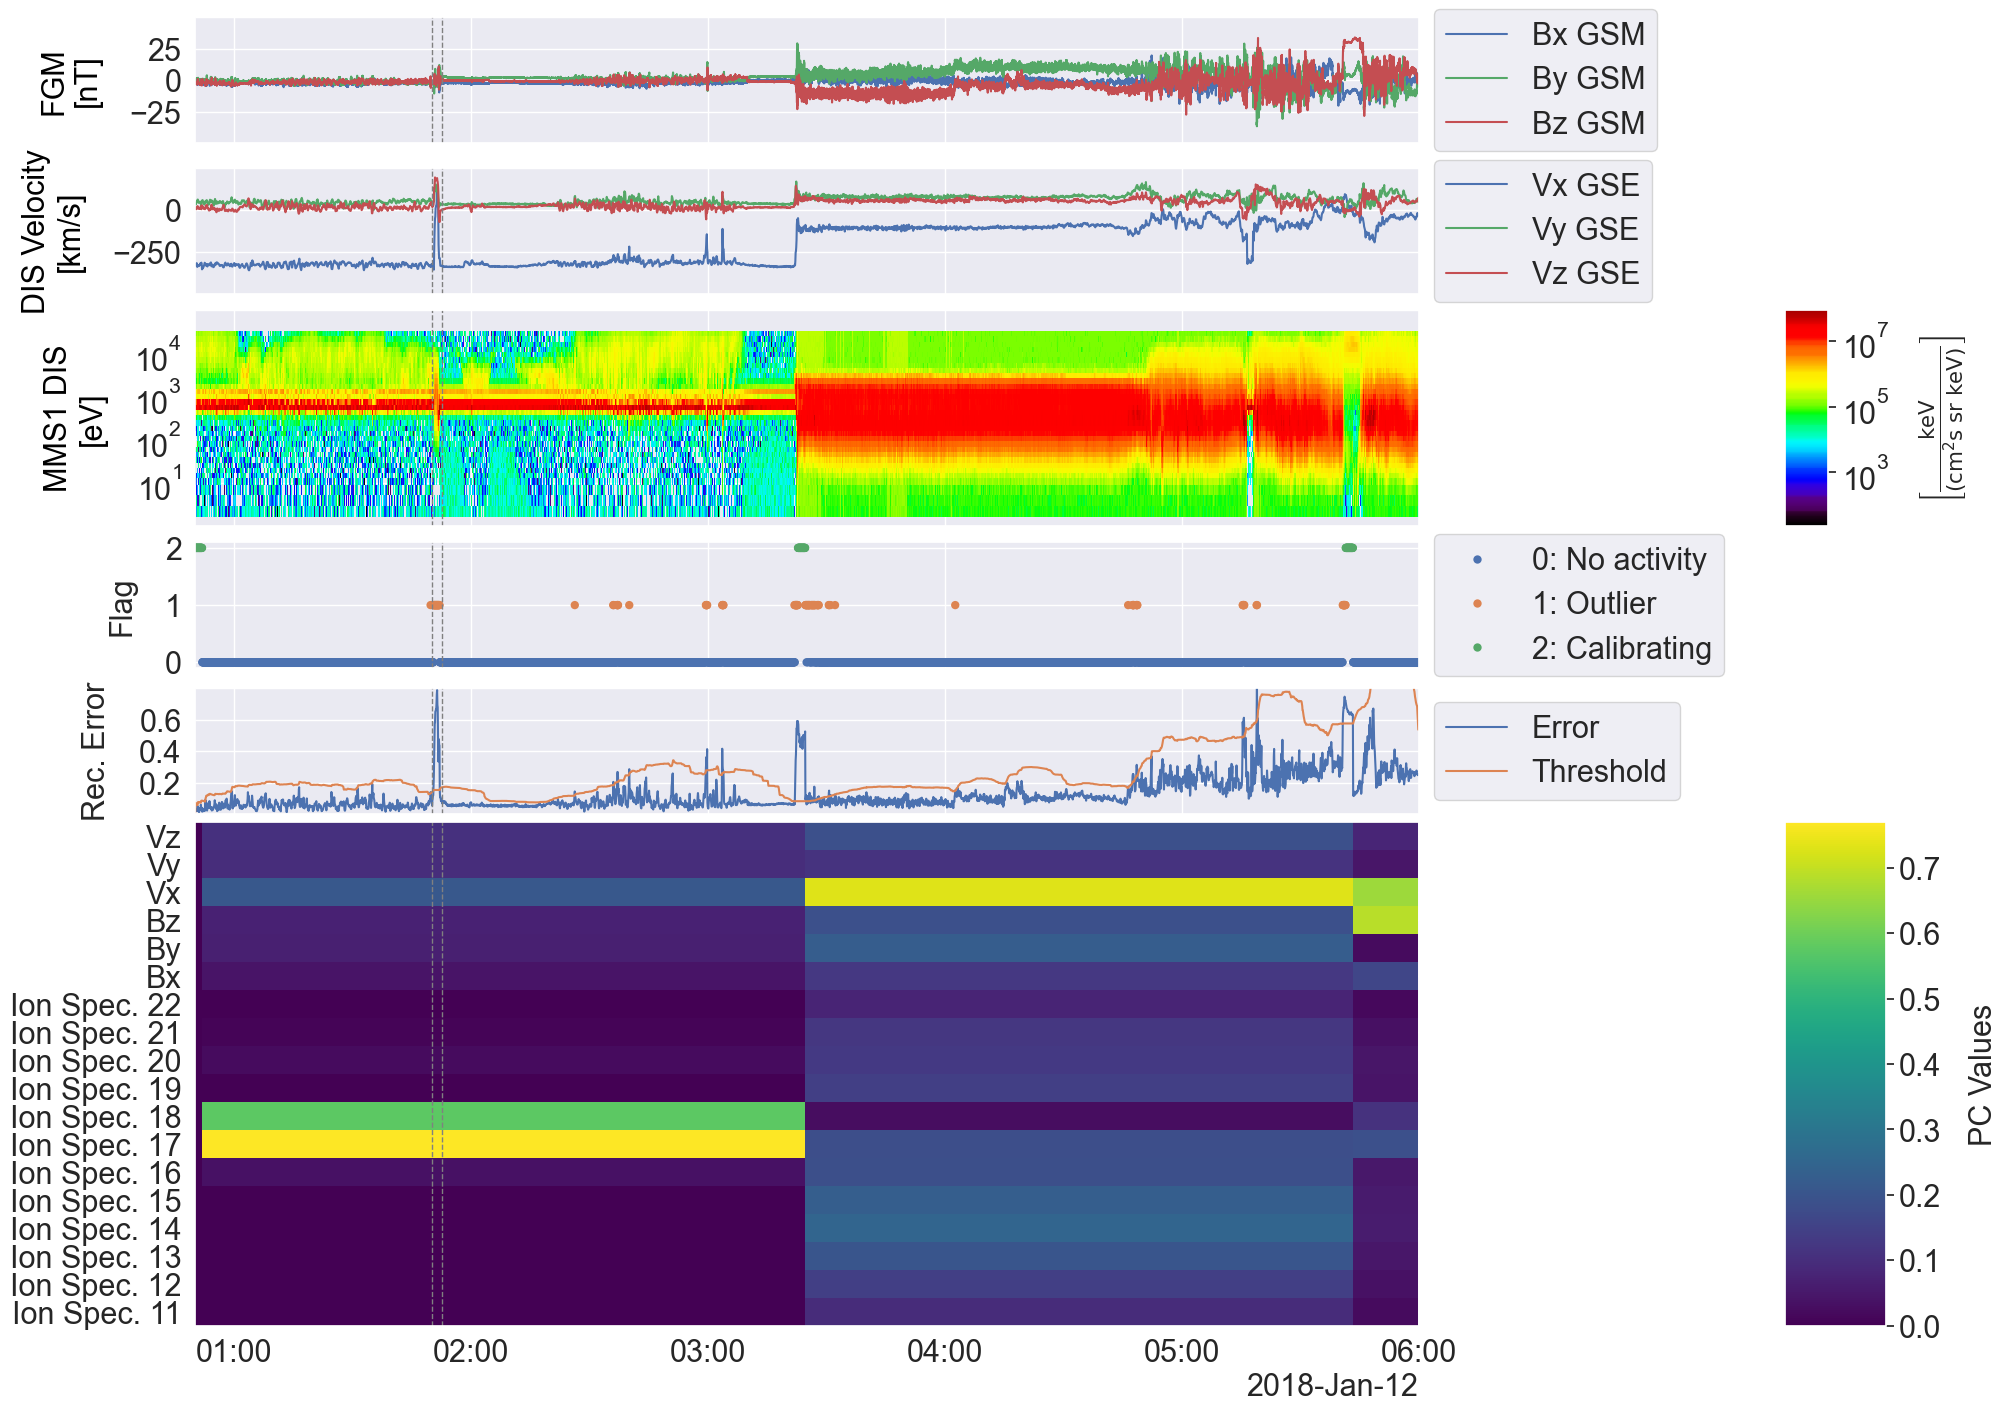

In [5]:
import os
from pyspedas import mms
import pytplot
from pytplot import tplot
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from pytplot import spedas_colorbar
_colors = [np.array([r,g,b]).astype(np.float64)/256
           for r,g,b in zip(spedas_colorbar.r, spedas_colorbar.g, spedas_colorbar.b)]
cmap = colors.LinearSegmentedColormap.from_list('spedas', _colors)

sns.set_theme()
plt.style.use('lncs_style_1.mplstyle')
vmin = np.min(np.abs(np.array([c[0] for c in data['Components']])))
vmax = np.max(np.abs(np.array([c[0] for c in data['Components']])))
d = datasets[2]
file = d['name']
trange = d['trange']
mms.fpi(trange=trange, datatype='dis-moms', time_clip=True)
mms.fgm(trange=trange, time_clip=True)
trange = (datetime.strptime(trange[0], '%Y-%m-%d/%H:%M:%S'),
                    datetime.strptime(trange[1], '%Y-%m-%d/%H:%M:%S'))

fig, axs = plt.subplots(6, sharex=True, gridspec_kw={'hspace': 0.01, 'height_ratios': [0.7,0.7,1.2,0.7, 0.7, 2.8]},
                       layout='constrained')
fig.set_figheight(5.6*2.5)
i = 0
var_name = 'mms1_fgm_b_gsm_srvy_l2_bvec'
tplot(var_name, qt=False, fig=fig, axis=axs[i], display = False);
axs[i].set_ylabel('FGM\n[nT]')
for line in axs[i].get_lines():
    line.set_linewidth(1.5)
i += 1
var_name = 'mms1_dis_bulkv_gse_fast'
tplot(var_name, qt=False, fig=fig, axis=axs[i], display = False);
axs[i].set_ylabel('DIS Velocity\n[km/s]')
for line in axs[i].get_lines():
    line.set_linewidth(1.5)
i += 1
var_name = 'mms1_dis_energyspectr_omni_fast'
tplot(var_name, qt=False, fig=fig, axis=axs[i], display = False);
pcm = axs[i].collections[-1]
pcm.colorbar.remove()
fig.colorbar(pcm, ax=axs[i], aspect=5, label=r'$\left[\frac{\text{keV}}{(\text{cm}^2 \text{s sr keV})}\right]$')
axs[i].set_ylim([5*10**1,1.5*10**3])
i += 1
data_l = data.loc[(data['Dataset']==file)]
hue_order = ['0: No activity', '1: Outlier', '2: Calibrating']
sns.scatterplot(data_l, x = 'Time', y = 'Flag', hue='Flag ', hue_order=hue_order, ax=axs[i],linewidth=0)
axs[i].yaxis.set_major_locator(plt.MaxNLocator(5))
axs[i].set_yticks([0,1,2])
axs[i].set_ylim([-0.1, 2.1])

i+=1
tmp = pd.melt(data_l, id_vars = 'Time', value_vars = ['Error', 'Threshold'], value_name='Rec. Error')
sns.lineplot(tmp, x = 'Time', y = 'Rec. Error', hue = 'variable', linewidth = 1.5, ax=axs[i])
axs[i].set_ylim([0,0.8])
axs[i].yaxis.set_major_locator(plt.MaxNLocator(4))

i+=1
#0-7    24-31
c = np.array([np.abs(c[0]) for c in data_l['Components']]).T
index = [i for i in range(11,23)] + [i for i in range(32, 38)]
c = c[index,:]
y_l = [[l for l in data['Features'].iloc[0]][i] for i in index]
y = np.arange(0,len(y_l))
X,Y = np.meshgrid(data_l['Time'], y)
pc =  axs[i].pcolormesh(X,Y,c,vmin=vmin, vmax=vmax, cmap = 'viridis')
fig.colorbar(pc, ax=axs[i], aspect=5, label=r'PC Values')
axs[i].set_yticks(y, y_l)
axs[i].set_xlabel('')
for ax in axs:
    ax.set_xlim(trange)
    ax.set_yticks(ax.get_yticks())
    labels = ax.get_yticklabels()
    if ax != axs[-1] and ax != axs[3]:
        labels[0] = ''
        labels[-1] = ''
    ax.set_yticklabels(labels, fontsize = 22)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 22)
    if d['roi']:
        for t1,t2 in d['roi']:
            ax.axvline(x=t1, linestyle='dashed', linewidth=1, c='grey')
            ax.axvline(x=t2, linestyle='dashed', linewidth=1, c='grey')
for i in [0,1,3,4]:
    axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
#fig.set_layout_engine('constrained')
output = file.split('/')[1].split('.')[0]
fig.savefig(f'figures/p_{output}_multi-feature.png')


In [6]:
from detector import OutlierDetector
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from dataset import PandasDataset
from detector import FeatureCoupledMinMaxScaler

calib_batch_size = 25
n_components = 2
mean_window = 150
outlier_limit = 10
error_threshold = 5
data_cols = [f'Ion Spec. {i}' for i in range(32)] + ['Bx', 'By', 'Bz'] + ['Vx', 'Vy', 'Vz'] 
reset_detector = False

#                                     Spec , B-field, Vel,   
scalar = FeatureCoupledMinMaxScaler([(0,32),(32,35), (35,36)], (0,1))

file = datasets[0]['name']
dataset = PandasDataset(file, return_index=False, data_columns=data_cols)
x, = next(iter(DataLoader(dataset, batch_size = len(dataset))))
scalar.fit(x.numpy())

def trans(x):
    return scalar.transform(x.reshape(1,-1))[0]
    
detector = OutlierDetector(n_components = n_components, outlier_limit = outlier_limit,
                           error_threshold = error_threshold, mean_window = mean_window)

data = None
rois = []
for d in datasets:
    file = d['name']
    if reset_detector:
        detector = OutlierDetector(n_components = n_components, outlier_limit = outlier_limit,
                           error_threshold = error_threshold, mean_window = mean_window)
    dataset = PandasDataset(file, return_index=False, data_columns=data_cols, transform = trans)
    tmp = run_detector(detector, dataset, calib_batch_size)
    tmp['Dataset'] = file
    tmp['Features'] = [dataset.data_columns for _ in range(len(tmp))]
    data = pd.concat([data,tmp])
    if d['roi']:
        rois.extend(d['roi'])
    detector.reset_mean()

06-Mar-25 08:33:19: Loading pydata/mms1/fpi/fast/l2/dis-moms/2021/02/mms1_fpi_fast_l2_dis-moms_20210213080000_v3.4.0.cdf
06-Mar-25 08:33:19: Loading pydata/mms1/fpi/fast/l2/dis-moms/2021/02/mms1_fpi_fast_l2_dis-moms_20210213100000_v3.4.0.cdf
06-Mar-25 08:33:19: Loading pydata/mms1/fpi/fast/l2/dis-moms/2021/02/mms1_fpi_fast_l2_dis-moms_20210213120000_v3.4.0.cdf
06-Mar-25 08:33:19: Loading pydata/mms1/fpi/fast/l2/dis-moms/2021/02/mms1_fpi_fast_l2_dis-moms_20210213140000_v3.4.0.cdf
06-Mar-25 08:33:20: The name mms1_dis_pitchangdist_lowen_fast is currently not in pytplot
06-Mar-25 08:33:20: The name mms1_dis_pitchangdist_miden_fast is currently not in pytplot
06-Mar-25 08:33:20: The name mms1_dis_pitchangdist_highen_fast is currently not in pytplot
06-Mar-25 08:33:20: Loading pydata/mms1/fgm/srvy/l2/2021/02/mms1_fgm_srvy_l2_20210213_v5.285.0.cdf
06-Mar-25 08:33:25: /opt/jupyter_venvs/pytorch/lib/python3.12/site-packages/pytplot/MPLPlotter/tplot.py:120: UserWarning: This figure was using a 

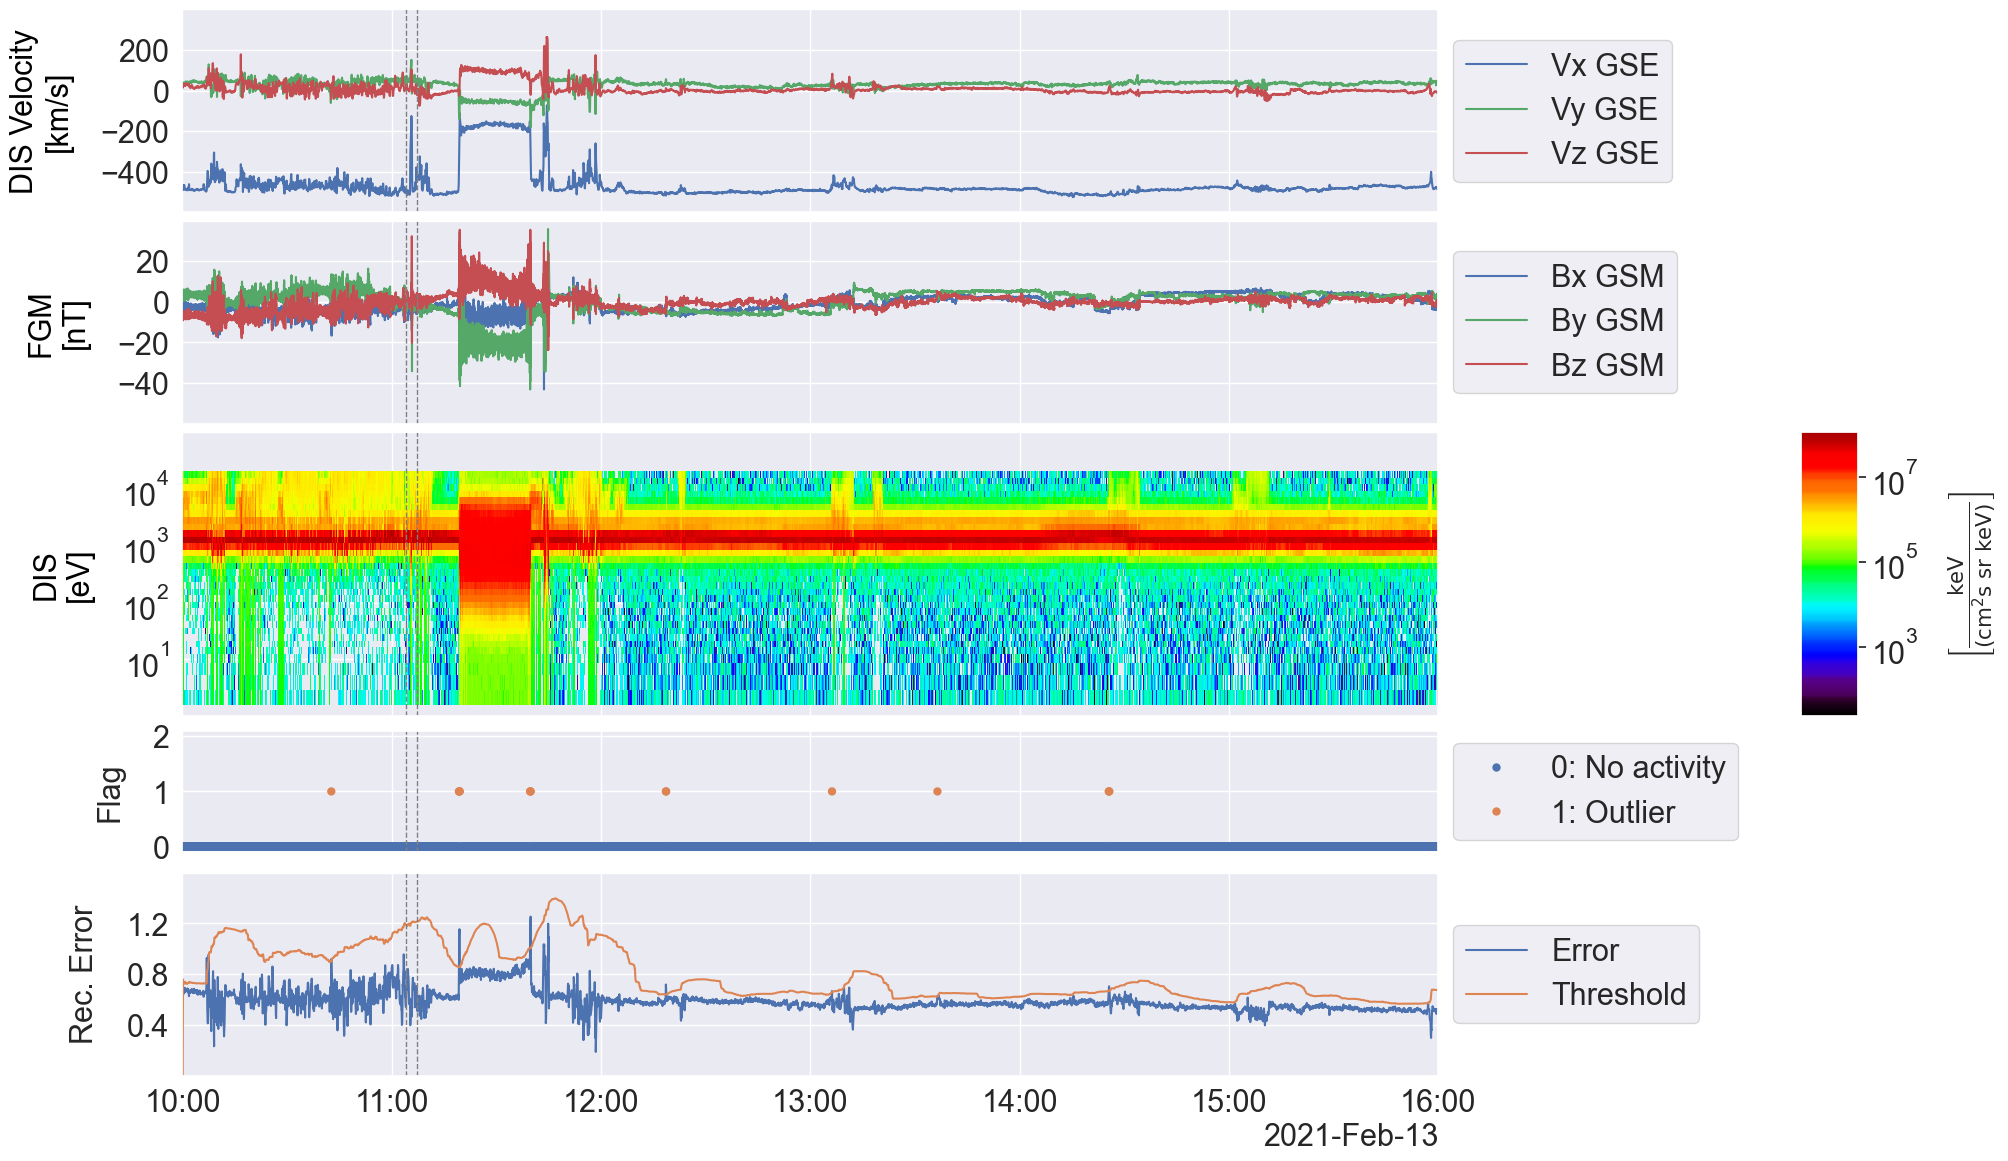

In [7]:
import os
from pyspedas import mms
import pytplot
from pytplot import tplot
from datetime import datetime, timedelta

vmin = np.min(np.abs(np.array([c[0] for c in data['Components']])))
vmax = np.max(np.abs(np.array([c[0] for c in data['Components']])))
d = datasets[7]
file = d['name']
trange = d['trange']
mms.fpi(trange=trange, datatype='dis-moms', time_clip=True)
mms.fgm(trange=trange, time_clip=True)
trange = (datetime.strptime(trange[0], '%Y-%m-%d/%H:%M:%S'),
                    datetime.strptime(trange[1], '%Y-%m-%d/%H:%M:%S'))

sns.set_theme()
plt.style.use('lncs_style_1.mplstyle')
fig, axs = plt.subplots(5, sharex=True, gridspec_kw={'hspace': 0.01, 'height_ratios': [1, 1, 1.4, 0.6, 1]},
                       layout='constrained')
fig.set_figheight(4.6*2.5)
i = 0
var_name = 'mms1_dis_bulkv_gse_fast'
tplot(var_name, qt=False, fig=fig, axis=axs[i], display = False);
for line in axs[i].get_lines():
    line.set_linewidth(1.5)
axs[i].set_ylabel('DIS Velocity\n[km/s]')
i+=1
var_name = 'mms1_fgm_b_gsm_srvy_l2_bvec'
tplot(var_name, qt=False, fig=fig, axis=axs[i], display = False);
for line in axs[i].get_lines():
    line.set_linewidth(1.5)
axs[i].set_ylabel('FGM\n[nT]')
i+=1
var_name = 'mms1_dis_energyspectr_omni_fast'
tplot(var_name, qt=False, fig=fig, axis=axs[i], display = False);
for line in axs[i].get_lines():
    line.set_linewidth(1.5)
axs[i].set_ylabel('DIS\n[eV]')
axs[i].set_ylim([5*10**1,1.5*10**3])
pcm = axs[i].collections[-1]
pcm.colorbar.remove()
fig.colorbar(pcm, ax=axs[i], aspect=5, label=r'$\left[\frac{\text{keV}}{(\text{cm}^2 \text{s sr keV})}\right]$')
i+=1
data_l = data.loc[(data['Dataset']==file)]
hue_order = ['0: No activity', '1: Outlier' ]#, '2: Calibrating']
sns.scatterplot(data_l, x = 'Time', y = 'Flag', hue='Flag ', hue_order=hue_order, ax=axs[i],linewidth=0)
axs[i].yaxis.set_major_locator(plt.MaxNLocator(5))
axs[i].set_yticks([0,1,2])
axs[i].set_ylim([-0.1, 2.1])

i+=1
tmp = pd.melt(data_l, id_vars = 'Time', value_vars = ['Error', 'Threshold'], value_name='Rec. Error')
sns.lineplot(tmp, x = 'Time', y = 'Rec. Error', hue = 'variable', ax=axs[i], linewidth=1.5)
axs[i].set_ylim([0,1.3])
axs[i].yaxis.set_major_locator(plt.MaxNLocator(4))
data_l.loc[data_l['Outlier']==True].to_csv('region_7_deviations.csv')
data_l.to_csv('region_7.csv')

axs[i].set_xlabel('')
for ax in axs:
    ax.set_xlim(trange)
    ax.set_yticks(ax.get_yticks())
    labels = ax.get_yticklabels()
    if ax != axs[3]:
        labels[0] = ''
        labels[-1] = ''
    ax.set_yticklabels(labels, fontsize = 22)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 22)
    if d['roi']:
        for t1,t2 in d['roi']:
            #relax the times for the ROI to make the plot clearer
            t1 -= timedelta(minutes = 1)
            t2 += timedelta(minutes = 1)
            ax.axvline(x=t1, linestyle='dashed', linewidth=1, c='grey')
            ax.axvline(x=t2, linestyle='dashed', linewidth=1, c='grey')
for i in [0,1,3,4]:
    axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
output = file.split('/')[1].split('.')[0]
fig.savefig(f'figures/p_{output}_hard.png')
    

# Nightside data

In [8]:
from detector import OutlierDetector
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from dataset import PandasDataset
from detector import FeatureCoupledMinMaxScaler
from dataset import get_dataset
datasets = get_dataset('night')

calib_batch_size = 25
n_components = 3
mean_window = 150
outlier_limit = 10
error_threshold = 3.5
var_list = ['mms1_dis_energyspectr_omni_fast', 'mms1_fgm_b_gsm_srvy_l2',
                 'mms1_dis_bulkv_gse_fast']
data_cols = [f'Ion Spec. {i}' for i in range(32)] + ['Bx', 'By', 'Bz'] + ['Vx', 'Vy', 'Vz']
    
data = None
rois = []
for d in datasets:
    file = d['name']
    dataset = PandasDataset(file, return_index=False, data_columns=data_cols)
    x, = next(iter(DataLoader(dataset, batch_size = len(dataset))))
    scalar = FeatureCoupledMinMaxScaler([(0,32),(32,35), (35,38)], (0,1))
    scalar.fit(x.numpy())
    def trans(x):
        return scalar.transform(x.reshape(1,-1))[0]
    detector = OutlierDetector(n_components = n_components, outlier_limit = outlier_limit,
                       error_threshold = error_threshold, mean_window = mean_window)
    dataset = PandasDataset(file, return_index=False, data_columns=data_cols, transform = trans)
    tmp = run_detector(detector, dataset, calib_batch_size)
    tmp['Dataset'] = file
    tmp['Features'] = [dataset.data_columns for _ in range(len(tmp))]
    data = pd.concat([data,tmp])
    if d['roi']:
        rois.extend(d['roi'])


06-Mar-25 08:33:39: Loading pydata/mms1/fpi/fast/l2/dis-moms/2017/07/mms1_fpi_fast_l2_dis-moms_20170723100000_v3.4.0.cdf
06-Mar-25 08:33:39: Loading pydata/mms1/fpi/fast/l2/dis-moms/2017/07/mms1_fpi_fast_l2_dis-moms_20170723120000_v3.4.0.cdf
06-Mar-25 08:33:39: Loading pydata/mms1/fpi/fast/l2/dis-moms/2017/07/mms1_fpi_fast_l2_dis-moms_20170723140000_v3.4.0.cdf
06-Mar-25 08:33:39: Loading pydata/mms1/fpi/fast/l2/dis-moms/2017/07/mms1_fpi_fast_l2_dis-moms_20170723160000_v3.4.0.cdf
06-Mar-25 08:33:40: The name mms1_dis_pitchangdist_lowen_fast is currently not in pytplot
06-Mar-25 08:33:40: The name mms1_dis_pitchangdist_miden_fast is currently not in pytplot
06-Mar-25 08:33:40: The name mms1_dis_pitchangdist_highen_fast is currently not in pytplot
06-Mar-25 08:33:41: Loading pydata/mms1/fgm/srvy/l2/2017/07/mms1_fgm_srvy_l2_20170723_v5.98.0.cdf
06-Mar-25 08:33:46: /opt/jupyter_venvs/pytorch/lib/python3.12/site-packages/pytplot/MPLPlotter/tplot.py:120: UserWarning: This figure was using a l

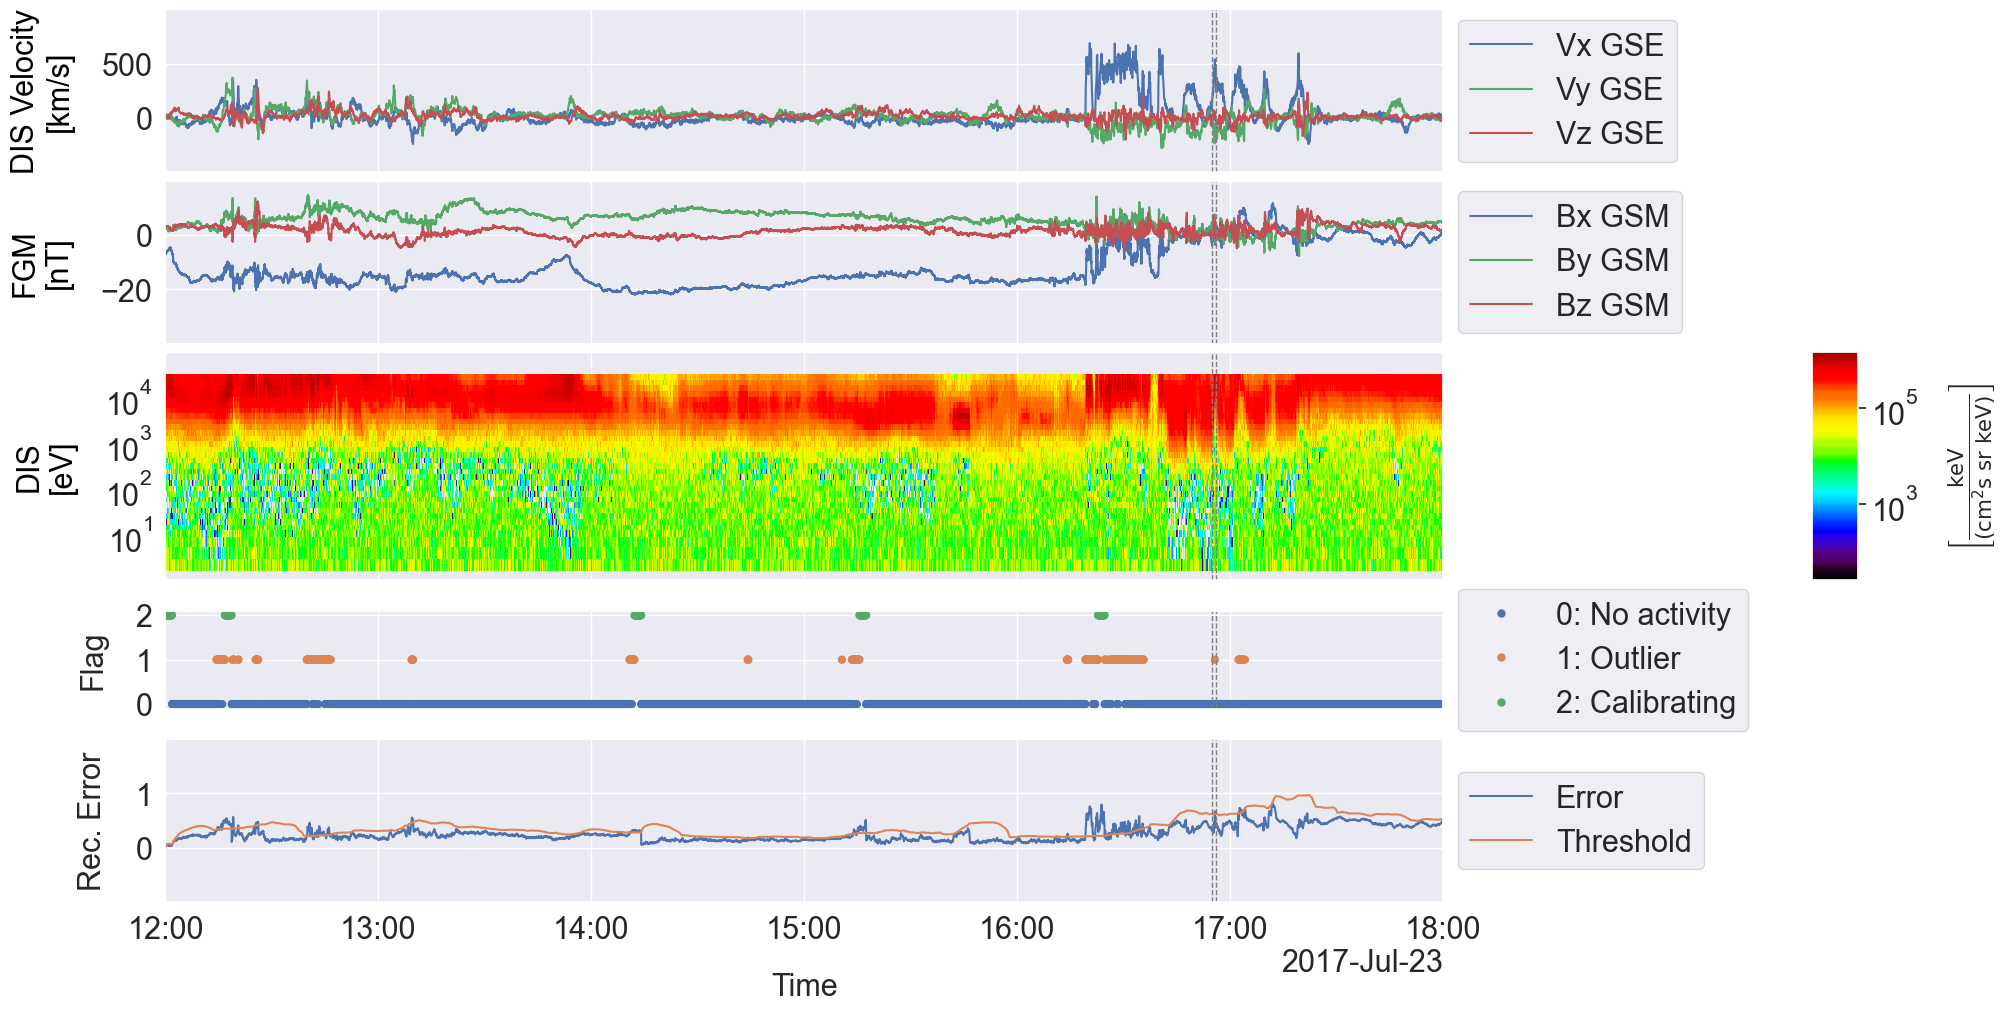

In [9]:
import os
from pyspedas import mms
import pytplot
from pytplot import tplot
from datetime import datetime

vmin = np.min(np.abs(np.array([c[0] for c in data['Components']])))
vmax = np.max(np.abs(np.array([c[0] for c in data['Components']])))

datasets = get_dataset('night')
d = datasets[0]
file = d['name']
trange = d['trange']
mms.fpi(trange=trange, datatype='dis-moms', time_clip=True)
mms.fgm(trange=trange, time_clip=True)
trange = (datetime.strptime(trange[0], '%Y-%m-%d/%H:%M:%S'),
                    datetime.strptime(trange[1], '%Y-%m-%d/%H:%M:%S'))

sns.set_theme()
plt.style.use('lncs_style_1.mplstyle')
fig, axs = plt.subplots(5, sharex=True, gridspec_kw={'hspace': 0.01,  'height_ratios': [1, 1, 1.4, 0.6, 1]},
                       layout='constrained')
fig.set_figheight(10)
i = 0
var_name = 'mms1_dis_bulkv_gse_fast'
tplot(var_name, qt=False, fig=fig, axis=axs[i], display = False);
for line in axs[i].get_lines():
    line.set_linewidth(1.5)
axs[i].set_ylabel('DIS Velocity\n[km/s]')
i+=1
var_name = 'mms1_fgm_b_gsm_srvy_l2_bvec'
tplot(var_name, qt=False, fig=fig, axis=axs[i], display = False);
for line in axs[i].get_lines():
    line.set_linewidth(1.5)
axs[i].set_ylabel('FGM\n[nT]')
i+=1
var_name = 'mms1_dis_energyspectr_omni_fast'
tplot(var_name, qt=False, fig=fig, axis=axs[i], display = False);
for line in axs[i].get_lines():
    line.set_linewidth(1.5)
axs[i].set_ylabel('DIS\n[eV]')
axs[i].set_ylim([5*10**1,1.2*10**3])
pcm = axs[i].collections[-1]
pcm.colorbar.remove()
fig.colorbar(pcm, ax=axs[i], aspect=5, label=r'$\left[\frac{\text{keV}}{(\text{cm}^2 \text{s sr keV})}\right]$')

i+=1
data_l = data.loc[(data['Dataset']==file)]
hue_order = ['0: No activity', '1: Outlier', '2: Calibrating']
sns.scatterplot(data_l, x = 'Time', y = 'Flag', hue='Flag ', hue_order=hue_order, ax=axs[i],linewidth=0)
axs[i].yaxis.set_major_locator(plt.MaxNLocator(5))
axs[i].set_yticks([0,1,2])
axs[i].set_ylim([-0.1, 2.1])

i+=1
tmp = pd.melt(data_l, id_vars = 'Time', value_vars = ['Error', 'Threshold'], value_name='Rec. Error')
sns.lineplot(tmp, x = 'Time', y = 'Rec. Error', hue = 'variable', ax=axs[i], linewidth=1.5)

for ax in axs:
    ax.set_xlim(trange)
    ax.set_yticks(ax.get_yticks())
    labels = ax.get_yticklabels()
    if ax != axs[3]:
        labels[0] = ''
        labels[-1] = ''
    ax.set_yticklabels(labels, fontsize = 22)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 22)
    if d['roi']:
        for t1,t2 in d['roi']:
            ax.axvline(x=t1, linestyle='dashed', linewidth=1, c='grey')
            ax.axvline(x=t2, linestyle='dashed', linewidth=1, c='grey')
for i in [0,1,3,4]:
    axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
output = file.split('/')[1].split('.')[0]
fig.savefig(f'figures/p_{output}_night_2.png')

# Themis

06-Mar-25 08:33:48: Downloading remote index: https://themis.ssl.berkeley.edu/data/themis/thc/l2/mom/2008/
06-Mar-25 08:36:51: File is current: themis_data/thc/l2/mom/2008/thc_l2_mom_20080714_v01.cdf
06-Mar-25 08:36:54: Downloading remote index: https://themis.ssl.berkeley.edu/data/themis/thc/l2/mom/2008/
06-Mar-25 08:39:51: File is current: themis_data/thc/l2/mom/2008/thc_l2_mom_20080714_v01.cdf
06-Mar-25 08:39:52: /opt/jupyter_venvs/pytorch/lib/python3.12/site-packages/pytplot/MPLPlotter/tplot.py:120: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=xmargin[0], right=1-xmargin[1])

06-Mar-25 08:39:52: /opt/jupyter_venvs/pytorch/lib/python3.12/site-packages/pytplot/MPLPlotter/tplot.py:128: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=vertica

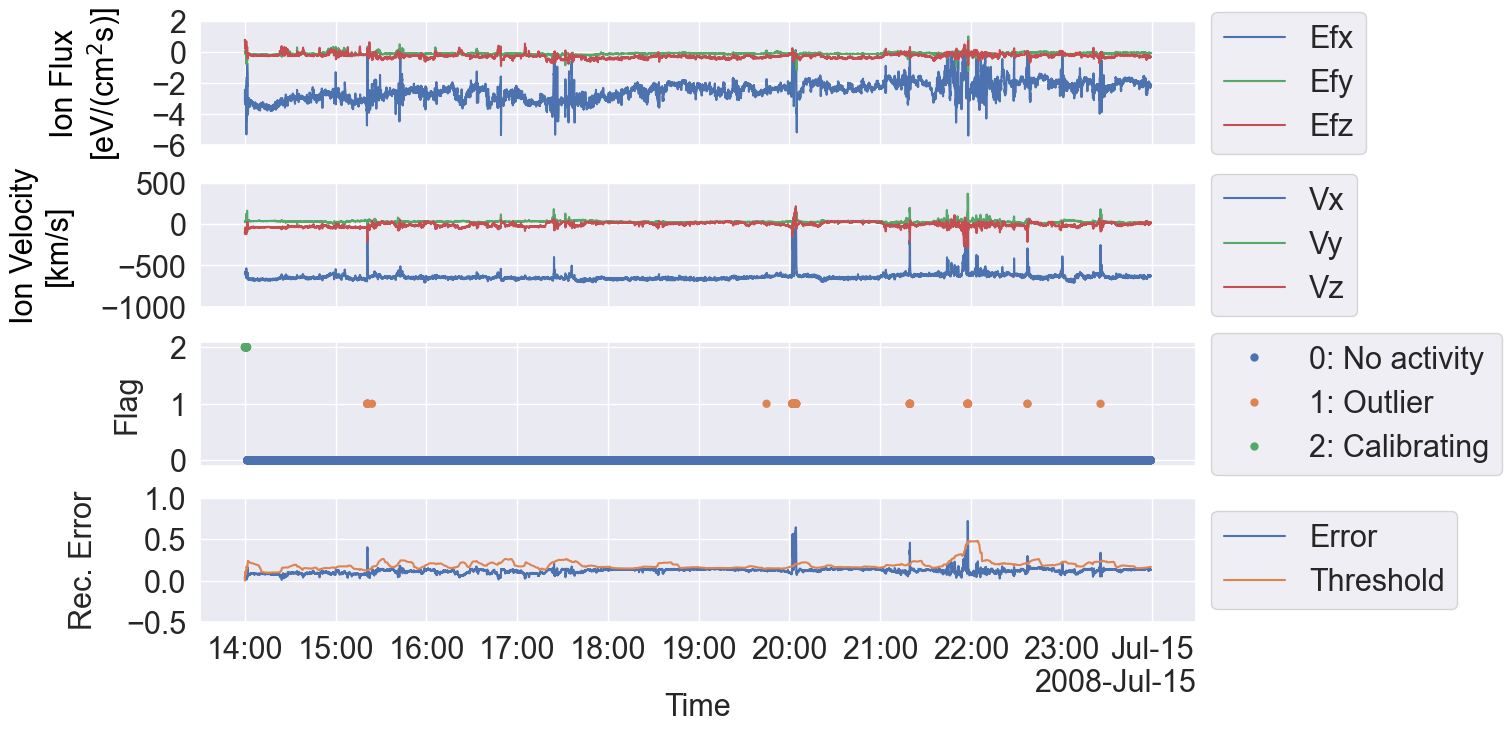

In [10]:
import pandas as pd
from pyspedas import themis,tplot
from torch.utils.data import Dataset, DataLoader
from detector import OutlierDetector, FeatureCoupledMinMaxScaler, run_detector
from dataset import PandasDataset, SpedasWrapper
import matplotlib.pyplot as plt
import seaborn as sns

trange = ['2008-07-14/14:00:00', '2008-07-14/23:59:00']
probe = 'c'
#Load the data
themis.mom(trange=trange, probe=probe, time_clip=True)
var = ['peim_eflux', 'peim_velocity_gse']
var = ['th'+probe+'_'+v for v in var]

#Create dataset and fit scaler
dataset = SpedasWrapper([(v,None) for v in var])
tmp = pd.DataFrame()
tmp['Time'] = dataset.dataset.index
scaler = FeatureCoupledMinMaxScaler(dataset.features, (0,1))
x, = next(iter(DataLoader(dataset, batch_size = len(dataset))))
scaler.fit(x.numpy())
def trans(x):
    return scaler.transform(x.reshape(1,-1))[0]
dataset = SpedasWrapper([(v,None) for v in var], transform=trans)

#Outlier detector parameters
calib_batch_size = 30
n_components = 2
mean_window = 180
outlier_limit = 10
error_threshold = 5

#Run outllier detection.
detector = OutlierDetector(n_components = n_components, outlier_limit = outlier_limit,
                           error_threshold = error_threshold, mean_window = mean_window)
data = run_detector(detector, dataset, calib_batch_size)
data['Features'] = [dataset.dataset.columns for _ in range(len(data))]

#Plot 
sns.set_theme()
plt.style.use('lncs_style_1.mplstyle')
fig, axs = plt.subplots(2+len(var), sharex=True, gridspec_kw={'hspace': 0}, figsize = (15,6),
                       layout='constrained')
fig.set_figheight(len(axs)*1.8)

themis.mom(trange=trange, probe=probe, time_clip=True)
i = 0

for v in var:
    tplot(v, qt=False, fig=fig, axis=axs[i], display = False);
    for line in axs[i].get_lines():
        line.set_linewidth(1.5)
    i+=1
axs[0].set_ylabel(r'Ion Flux' + '\n' + r'[eV/(cm$^2$s)]')
axs[1].set_ylabel(r'Ion Velocity' + '\n' + r'[km/s]')
data_l = data

hue_order = ['0: No activity', '1: Outlier', '2: Calibrating']
sns.scatterplot(data_l, x = 'Time', y = 'Flag', hue='Flag ', hue_order=hue_order, ax=axs[i],linewidth=0)
axs[i].yaxis.set_major_locator(plt.MaxNLocator(5))
axs[i].set_yticks([0,1,2])
axs[i].set_ylim([-0.1, 2.1])
i+=1

tmp = pd.melt(data_l, id_vars = 'Time', value_vars = ['Error', 'Threshold'], value_name='Rec. Error')
sns.lineplot(tmp, x = 'Time', y = 'Rec. Error', hue = 'variable', ax=axs[i], linewidth=1.5)

for ax in axs:
    ax.set_yticks(ax.get_yticks())
    labels = ax.get_yticklabels()
    ax.set_yticklabels(labels, fontsize = 22)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 22)
    
leg = [['Efx', 'Efy', 'Efz'],
    ['Vx', 'Vy', 'Vz'], None, None]
for i in [0,1,2,3]:
    if leg[i] is None: 
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        axs[i].legend(labels=leg[i],loc='center left', bbox_to_anchor=(1, 0.5))
    
fig.savefig('figures/themis.png')
data_l.loc[data_l['Outlier']].to_csv('themis_c_Outliers.csv')
